<a href="https://colab.research.google.com/github/aileeny825/Text_Analysis_Final_Project/blob/main/final_project_Aileen%20Yang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Rhetorical Architecture of Mayor Adams’ Housing Policy
By Aileen Yang cy2830

**Research Question:** How does the Adams administration balance different themes, such as supportive services, rental affordability, and construction in its public messaging on affordable housing?

## Introduction

**Background**

New York City’s affordable housing crisis is one of the most defining policy challenges of the Adams administration for nearly four years, which will continue to burden the new Mamdani administration.

New York City’s affordable housing crisis is not merely a logistical shortage of units; it is a crisis of confidence. For the Adams administration, the challenge is dual: technically managing a housing shortage while politically managing a constituency skeptical of development.

With the "City of Yes" initiative facing pivotal votes, the administration’s public messaging is a critical tool of governance. This project investigates the research question: How does the Adams administration balance different themes, such as supportive services, rental affordability, and construction, in its public messaging on affordable housing?


By analyzing 27 official transcripts—ranging from press conferences to bill signings—this project moves beyond surface-level readings to uncover the statistical patterns of the Mayor’s rhetoric. The analysis tests the hypothesis that the administration is attempting to "re-brand" development by linguistically fusing it with social services, thereby neutralizing opposition to new construction.
<br><br>

**Methodology**

To answer this research question, two techniques were applied:

**1. TF-IDF (Term Frequency-Inverse Document Frequency):**

This method was chosen to identify the administration's distinctive vocabulary. Unlike simple word counts, TF-IDF penalizes generic terms (like "people" or "city") to reveal the specific policy terms that define the Mayor's unique rhetorical signature.

**2. LDA (Latent Dirichlet Allocation):**

While TF-IDF isolates individual words, LDA is necessary to detect thematic structures. This probabilistic model assumes that each transcript is a mixture of underlying topics. By setting K=8 topics (determined via interpretability testing), this method allows us to see how the Mayor shifts "frames" depending on the context—moving from a "sympathetic" frame for shelter announcements to a "triumphant" frame for legislative victories.

## Data Collection & Cleaning

I first scraped the transcripts using a two stage extraction pipeline.

For each nyc.gov URL, I parsed the article via newspaper3k. Each transcript was saved as a separate .txt file with standardized filenames and a metadata header recording the URL, extractor, and timestamp.

### Corpus Construction

In [1]:
# Mount Drive & setup the working folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

folder_name = "housing_transcript"
drive_path = "/content/drive/MyDrive"
corpus_dir = os.path.join(drive_path, folder_name)

os.makedirs(corpus_dir, exist_ok=True)
print(f"✅ Folder ready: {corpus_dir}")


✅ Folder ready: /content/drive/MyDrive/housing_transcript


In [3]:
!pip -q install "numpy==2.0.2" "scipy==1.14.1" "scikit-learn>=1.4"
!pip install nltk==3.9.2

import numpy, scipy, sklearn
print("NumPy:", numpy.__version__)     # → 2.0.2
print("SciPy:", scipy.__version__)     # → 1.14.x
print("sklearn:", sklearn.__version__) # ≥ 1.4


import nltk
nltk.download('inaugural')
nltk.download('stopwords')
nltk.download('punkt')
# Some environments expect punkt_tab as well:
nltk.download('punkt_tab')

print("✅ Setup complete.")

NumPy: 2.0.2
SciPy: 1.14.1
sklearn: 1.6.1
✅ Setup complete.


[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
!pip install newspaper3k lxml_html_clean --quiet
# --- Imports ---
import os
import time
import pathlib
import datetime

import requests
from bs4 import BeautifulSoup
from newspaper import Article, Config

# HTTP headers
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

# Newspaper3k configuration
cfg = Config()
cfg.browser_user_agent = HEADERS["User-Agent"]
cfg.request_timeout = 20
cfg.memoize_articles = False

# Save txt files in "housing_transcript" folder
SAVE_DIR = pathlib.Path("/content/drive/MyDrive/housing_transcript")
SAVE_DIR.mkdir(parents=True, exist_ok=True)


# Helpers
def extract_with_newspaper(url: str) -> str:
  # Use newspaper3k to pull the transcript text from web
  # Use requests and BeautifulSoup if newspaper3k method fails
    art = Article(url, config=cfg)
    try:
        art.download()
        art.parse()
        return art.text.strip()
    except Exception:
        r = requests.get(url, headers=HEADERS, timeout=30)
        r.raise_for_status()
        art = Article(url, config=cfg)
        art.set_html(r.text)
        art.parse()
        return art.text.strip()


def extract_with_bs(url: str) -> str:
  #Backup text extractor
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")
    paragraphs = [p.get_text(" ", strip=True) for p in soup.find_all("p")]
    text = "\n\n".join(p for p in paragraphs if p)
    return text.strip()


def extract_article(url: str, i: int):
  # Use requests and BeautifulSoup if newspaper3k method fails
    try:
        text = extract_with_newspaper(url)
        source = "newspaper3k"
    except Exception as e1:
        try:
            text = extract_with_bs(url)
            source = "bs4"
        except Exception as e2:
            raise RuntimeError(
                f"Both extractors failed for {url}.\n"
                f"Newspaper err: {e1}\nBeautifulSoup err: {e2}"
            )
    return text, source


def safe_filename(title: str, i: int) -> str:
  # Turn the url into a standard form or filename with order
    base = "".join(c for c in title if c.isalnum() or c in (" ", "_")).strip()
    base = base.replace(" ", "_")
    if not base:
        base = f"article_{i}"
    return f"{i:02d}_{base[:60]}.txt"


# Main Save function
def save_article(urls):
    """
    For each URL:
      - Only keep nyc.gov URLs
      - Extract article text
      - Only save if URL contains 'transcript' AND URL/text contains 'housing'
      - Save to SAVE_DIR as a .txt file
    """
    for i, url in enumerate(urls, start=1):

        # Make sure data source is only from nyc.gov
        if "nyc.gov" not in url:
            print(f"⚠️ Skipped (not nyc.gov): {url}")
            continue

        try:
            text, source = extract_article(url, i)

            # Generate filename from url
            parts = [p for p in url.rstrip("/").split("/") if p]
            title_hint = parts[-1] if parts else "article"
            fname = safe_filename(title_hint, i)
            fpath = SAVE_DIR / fname

            with open(fpath, "w", encoding="utf-8") as f:
                f.write(f"URL: {url}\n")
                f.write(f"SourceExtractor: {source}\n")
                f.write(f"SavedAtUTC: {datetime.datetime.utcnow().isoformat()}Z\n\n")
                f.write(text)

            print(f"Saved ({source}): {fname}")
            time.sleep(1.0)

        except Exception as e:
            print(f"⚠️ Skipped {url} due to error: {e}")

# List of housing-related mayoral urls
urls = [
    "https://www.nyc.gov/mayors-office/news/2025/08/transcript--mayor-adams-most-pro-housing-administration-in-city-",
    "https://www.nyc.gov/mayors-office/news/2025/03/transcript-mayor-adams-dss-commissioner-wasow-park-celebrate-opening-deeply-affordable-housing",
    "https://www.nyc.gov/mayors-office/news/2025/09/transcript--mayor-adams-announces-progress-creating-nearly-10-00",
    "https://www.nyc.gov/mayors-office/news/2025/07/transcript--most-pro-housing-administration-in-city-history--may",
    "https://www.nyc.gov/office-of-the-mayor/news/259-25/transcript-mayor-adams-new-investments-upcoming-mayoral-budget-create-more-homes-",
    "https://www.nyc.gov/mayors-office/news/2025/07/transcript--mayor-adams--hpd--nypl-announce-new-program-to-deliv",
    "https://www.nyc.gov/mayors-office/news/2025/02/transcript-mayor-adams-back-to-back-record-breaking-years-creating-affordable",
    "https://www.nyc.gov/office-of-the-mayor/news/896-22/transcript-mayor-eric-adams-delivers-address-new-york-city-s-affordable-housing-crisis-and",
    "https://www.nyc.gov/office-of-the-mayor/news/596-24/transcript-mayor-adams-back-to-back-record-years-creating-connecting-new-yorkers",
    "https://www.nyc.gov/mayors-office/news/2025/05/transcript-mayor-adams-makes-housing-related-announcement-the-real-deal-nyc-forum-2025",
    "https://www.nyc.gov/office-of-the-mayor/news/178-25/transcript-mayor-adams-dss-commissioner-wasow-park-celebrate-opening-deeply-affordable-housing",
    "https://www.nyc.gov/mayors-office/news/2025/03/transcript-mayor-adams-nyc-health-hospitals-hpd-opening-93-units-affordable",
    "https://www.nyc.gov/office-of-the-mayor/news/526-24/transcript-mayor-adams-celebrates-historic-2-billion-investment-affordable-housing-total",
    "https://www.nyc.gov/office-of-the-mayor/news/694-23/transcript-mayor-adams-delivers-address-future-housing-nyc-holds-in-person-media",
    "https://www.nyc.gov/office-of-the-mayor/news/942-24/transcript-mayor-adams-administration-deliver-safer-more-affordable-new-york-city-2024",
    "https://www.nyc.gov/office-of-the-mayor/news/884-24/transcript-mayor-adams-holds-press-conference-the-passage-city-yes-housing",
    "https://www.nyc.gov/office-of-the-mayor/news/566-23/transcript-mayor-adams-record-breaking-year-creating-connecting-new-yorkers-to",
    "https://www.nyc.gov/mayors-office/news/2022/06/transcript-mayor-eric-adams-housing-our-neighbors-plan--blueprint-housing-and",
    "https://www.nyc.gov/office-of-the-mayor/news/380-23/transcript-mayor-adams-delivers-remarks-affordable-housing-rally",
    "https://www.nyc.gov/mayors-office/news/2025/05/transcript-mayor-adams-hosts-community-conversation",
    "https://www.nyc.gov/office-of-the-mayor/news/270-24/transcript-mayor-adams-celebrates-largest-all-affordable-housing-project-40-years-city-s-first",
    "https://www.nyc.gov/office-of-the-mayor/news/935-24/transcript-mayor-eric-adams-holds-bill-signing-ceremony-related-city-yes-housing",
    "https://www.nyc.gov/mayors-office/news/2023/03/transcript-mayor-adams-tours-offices-being-converted-homes-highlights-key-affordable-housing",
    "https://www.nyc.gov/office-of-the-mayor/news/952-23/transcript-mayor-adams-signs-bill-create-fair-housing-framework-more-equitable-housing",
    "https://www.nyc.gov/office-of-the-mayor/news/192-25/transcript-mayor-adams-provides-address-new-yorkers",
    "https://www.nyc.gov/office-of-the-mayor/news/013-25/transcript-mayor-adams-lays-out-ambitious-agenda-make-new-york-city-best-place-raise-a",
    "https://www.nyc.gov/office-of-the-mayor/news/303-24/transcript-mayor-adams-delivers-remarks-governor-hochul-s-housing-budget-announcement"

]

save_article(urls)
print("Folder:", SAVE_DIR)


/usr/local/lib/python3.12/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/tmp/ipython-input-2509574517.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"SavedAtUTC: {datetime.datetime.utcnow().isoformat()}Z\n\n")


Saved (newspaper3k): 01_transcriptmayoradamsmostprohousingadministrationincity.txt
Saved (newspaper3k): 02_transcriptmayoradamsdsscommissionerwasowparkcelebrateopening.txt
Saved (newspaper3k): 03_transcriptmayoradamsannouncesprogresscreatingnearly1000.txt
Saved (newspaper3k): 04_transcriptmostprohousingadministrationincityhistorymay.txt
Saved (newspaper3k): 05_transcriptmayoradamsnewinvestmentsupcomingmayoralbudgetcreat.txt
Saved (newspaper3k): 06_transcriptmayoradamshpdnyplannouncenewprogramtodeliv.txt


/usr/local/lib/python3.12/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Saved (newspaper3k): 07_transcriptmayoradamsbacktobackrecordbreakingyearscreatingaff.txt
Saved (newspaper3k): 08_transcriptmayorericadamsdeliversaddressnewyorkcitysaffordabl.txt
Saved (newspaper3k): 09_transcriptmayoradamsbacktobackrecordyearscreatingconnectingn.txt
Saved (newspaper3k): 10_transcriptmayoradamsmakeshousingrelatedannouncementtherealde.txt
Saved (newspaper3k): 11_transcriptmayoradamsdsscommissionerwasowparkcelebrateopening.txt
Saved (newspaper3k): 12_transcriptmayoradamsnychealthhospitalshpdopening93unitsaffor.txt
Saved (newspaper3k): 13_transcriptmayoradamscelebrateshistoric2billioninvestmentaffo.txt
Saved (newspaper3k): 14_transcriptmayoradamsdeliversaddressfuturehousingnycholdsinpe.txt
Saved (newspaper3k): 15_transcriptmayoradamsadministrationdeliversafermoreaffordable.txt
Saved (newspaper3k): 16_transcriptmayoradamsholdspressconferencethepassagecityyeshou.txt
Saved (newspaper3k): 17_transcriptmayoradamsrecordbreakingyearcreatingconnectingnewy.txt
Saved (newspaper3k): 

In [5]:

import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import inaugural, stopwords
from nltk import word_tokenize, FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, LatentDirichletAllocation


# Display all content when inspecting dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

print("Imports loaded.")


Imports loaded.


In [6]:
import glob
# Load the transcripts
folder = "/content/drive/MyDrive/housing_transcript/*.txt"
files = glob.glob(folder)

corpus = []
file_names = []

for f in files:
    with open(f, "r", encoding="utf-8") as src:
        text = src.read()
        corpus.append(text)
        file_names.append(f.split("/")[-1])


**Stopwords & Token Cleaning**

Since mayoral transcripts are full of pleasantries (“thank you, Commissioner…”) and filler (“you know, right?”), comprehensive cleaning is crucial.

I combined standard English stopwords with a custom stopword list that removes greetings, generic praise, and hyper-frequent terms like “city,” “New York,” “housing,” “people,” and the mayor’s own name.

On top of that, I restricted the analysis to content words, nouns and adjectives, so that the model focuses on what issues are being discussed rather than on auxiliary verbs or conversational tics.

This combination of aggressive stopwording and part-of-speech filtering is what allows TF–IDF and LDA to analyse substantive housing language instead of conversational noise.

In [7]:
nltk.download('averaged_perceptron_tagger_eng')
EN_STOP = set(stopwords.words('english'))
print("English stopwords:", EN_STOP)

# Customed stopwords, including greetings, filler speech, generic housing terms
CUSTOM_STOP = {
    'thank', 'thanks', 'today', 'tonight', 'morning', 'afternoon',
    'everyone', 'everybody', 'great', 'really', 'very', 'well',
    'good', 'like', 'just', 'now', 'going', 'say', 'said',
    'want', 'know', 'let', 'think','city', 'new', 'york', 'yorkers', 'nyc', 'state', 'government',
    'administration', 'public', 'department', 'agency', 'agencies',
    'officials', 'leaders','make', 'making', 'build', 'built', 'building', 'work', 'working',
    'important', 'incredible', 'amazing', 'awesome',
    'job', 'team', 'folks', 'people', 'families', 'housing', 'homes', 'home', 'affordable',  # appears in every article
    'unit', 'units', 'supply','plan', 'plans', 'program', 'mayor', 'one', 'get', 'got', 'going', 'yeah', 'okay', 'ok',
    'really', 'kind', 'sort', 'things', 'thing', 'lot',
    'just', 'like', 'question', 'questions', 'answer', 'answered', 'asking',
    'ask', 'asked', 'yes', 'no', 'right', 'sure', 'time', 'adams', 'commissioner', 'deputy', 'council','applause', 'cheers', 'government', 'nation', 'people',
    'states', 'united', 'american', 'america', 'may', 'angry', 'year year'
}
STOPWORDS = EN_STOP.union(CUSTOM_STOP)

def simple_clean_tokens(text):
  ### Normalization of
  # Lowercase, tokenize, keep alphabetic tokens, drop English & custom stopwords
    text = text.lower()
    tokens = word_tokenize(text)
    clean = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3 and tok not in STOPWORDS]
    return clean
from nltk import pos_tag
def content_tokens(text):
  ### Restrict to content words
  # Reduce influence of verbs, adverbs, speech fillers
    tokens = simple_clean_tokens(text)
    tagged = pos_tag(tokens)
    keep_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'}  # nouns & adjectives
    return [w for (w, tag) in tagged if (tag in keep_pos and w not in STOPWORDS)]

# Apply cleaning methods
cleaned_tokens = [content_tokens(doc) for doc in corpus]
cleaned_corpus = [" ".join(toks) for toks in cleaned_tokens]



[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


English stopwords: {'these', 'our', 'by', 'both', 'for', 'shouldn', 'that', 'them', 'when', 'she', 'some', "weren't", 'while', "you're", 'aren', 'should', 'above', "we'd", 'there', 'it', "she's", 'between', "hasn't", 'doesn', 'because', 'this', 'is', 'am', 'just', "she'll", 'your', 'where', 'll', 'does', 'than', 'against', "wouldn't", 'didn', 'in', 'now', "it's", 'hadn', 'shan', 'yours', 'same', 'yourselves', 'hers', 'herself', 'has', "mustn't", "isn't", 'its', "shan't", "couldn't", 'doing', 'under', 'or', 'own', 'during', "you'd", 'weren', 'before', "they've", "that'll", 'they', 'to', 'out', 'below', 'have', 'so', 't', "we've", 'any', 'couldn', 'wasn', "i'm", 'who', 'been', 'myself', 'from', 'him', "it'll", 'not', "i'd", 'no', 'can', 'few', "we'll", 'those', 'which', 'you', 'mustn', 'each', 'itself', "aren't", 'after', 'being', 'won', 'down', 'her', 'yourself', "you've", 'don', 'off', 'here', "they'll", 'into', "it'd", "they're", "wasn't", 'again', 'if', "you'll", 'over', "hadn't", "s

### TF-IDF Model

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(
    min_df=3,          # the word must appear in ≥ 3 transcripts
    max_df=0.6,        # drop words that appear in >60% of transcripts
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(cleaned_corpus)
terms = np.array(tfidf.get_feature_names_out())

print("TF–IDF shape:", X_tfidf.shape)


TF–IDF shape: (27, 2060)


In [9]:
# Returm the top n terms with highest TF-IDF scores

def top_tfidf_terms_for_doc(doc_idx, top_n=15):
    row = X_tfidf.getrow(doc_idx).toarray().ravel()
    top_idx = row.argsort()[::-1][:top_n]
    return list(zip(terms[top_idx], row[top_idx]))


### Global TF-IDF Bar Chart

With this cleaned corpus set, I built a TF–IDF representation that retains both unigrams and bigrams.

Globally averaging TF–IDF scores across the 27 transcripts produces a ranked list of the most distinctive housing-policy terms.

At the very top are words like “supportive,” “services,” “health,” “union,” “rent,” “programs,” “buildings,” “construction,” “apartments,” along with references to “streets,” “system,” “governor,” and “director.”

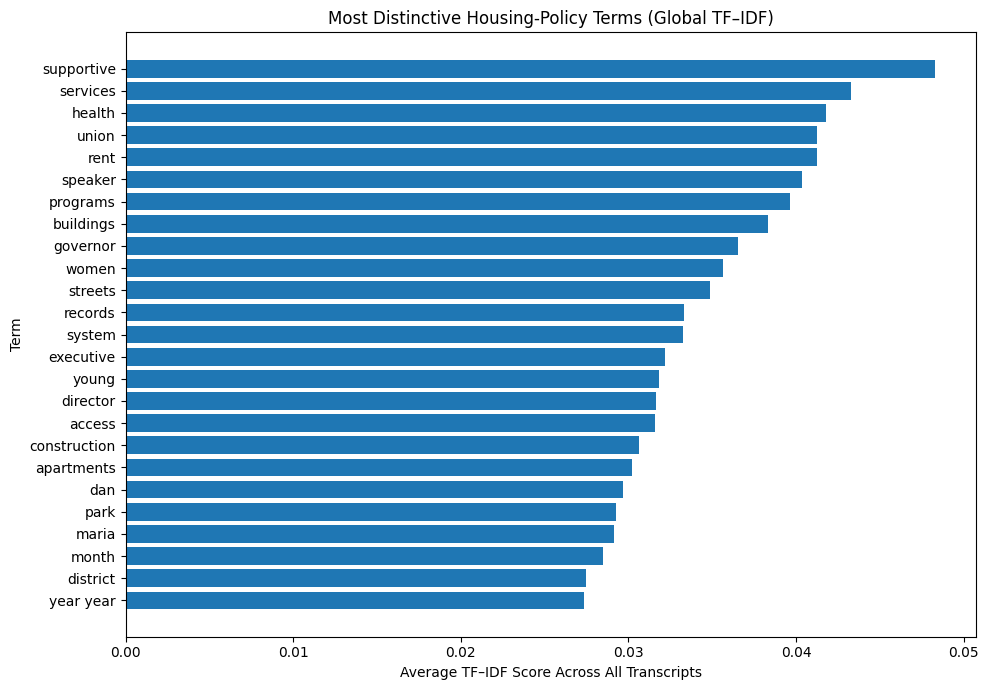

In [10]:
# Global average TF–IDF per term
# mean TF–IDF weight across all documents for each term
mean_tfidf = X_tfidf.mean(axis=0).A1

top_n = 25
top_idx = mean_tfidf.argsort()[::-1][:top_n]

global_terms = terms[top_idx]
global_scores = mean_tfidf[top_idx]

plt.figure(figsize=(10, 7))
plt.barh(global_terms, global_scores)
plt.xlabel("Average TF–IDF Score Across All Transcripts")
plt.ylabel("Term")
plt.title("Most Distinctive Housing-Policy Terms (Global TF–IDF)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Two patterns stands out from the rest.**



**Insight 1: The Fusion of "Bricks" and "Care"**

The most immediate insight derived from the Global TF-IDF analysis is the administration's refusal to bifurcate "building" and "caring." In traditional housing rhetoric, "development" is often pitted against "community protection." However, the data shows that the Adams administration consistently bridges this divide.

Terms like "supportive" (0.04 score), "services" (0.038), and "health" appear in the exact same high-frequency tier as "construction," "buildings," and "apartments". This co-occurrence is not accidental; it is a rhetorical strategy. By consistently linking "housing" with "supportive services," the administration redefines the product being delivered. They are not simply delivering "units", which is a cold, quantitative metric, but "homes with services."

This framing serves a distinct political purpose: it preemptively counters the critique that pro-development policies leave vulnerable populations behind. When the Mayor speaks of construction, he almost simultaneously speaks of mental health, implying that the city's physical infrastructure (buildings) is the necessary foundation for its social infrastructure (health).

**Insight 2: The Political Utility of Coalition Language**

A second pattern in the TF-IDF results is the prominence of governance and labor terminology.

Words such as "union," "governor," "speaker," and "partnership" rank exceptionally high. In many comparable housing policy corpora, technical terms (zoning, tax, subsidy) dominate. Here, the "who" is as important as the "what." The frequent invocation of "unions" and "labor" reframes the housing crisis as a jobs program. This recruits the political power of organized labor to the pro-development cause.

By framing a construction project not as a boon for real estate developers but as a source of "union jobs" for working class New Yorkers, the administration creates a moral permission structure for development.

Similarly, the high frequency of "governor" and "speaker" signals a "coalition style" of leadership. This defuses the risk of sole accountability.

If the housing crisis is a shared burden managed by a "team" of city and state leaders, the Mayor is positioned as a collaborator rather than the sole target for frustration.

This rhetorical "sharing of the stage" validates the administration's "City of Yes" slogan—implying that saying "yes" to housing is saying "yes" to a broad political consensus, not just a mayoral decree.

## Topic Modeling (LDA)

**Thematic Clusters: Deconstructing the "City of Yes"**

While TF-IDF highlights the vocabulary, the LDA topic model reveals the underlying narrative structures. The analysis suggests that the Mayor does not use one monolithic "housing speech." Instead, the model segregates the transcripts into distinct rhetorical "modes," effectively allowing the administration to code-switch based on the audience.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [12]:

# Bag of words count for LDA
cv = CountVectorizer(min_df=2)
X_counts = cv.fit_transform(cleaned_corpus)
vocab = np.array(cv.get_feature_names_out())

# Number of topics chosen: 8
K = 8
lda = LatentDirichletAllocation(
    n_components=K,
    learning_method="batch",
    random_state=42,
    max_iter=20
)

topic_mix = lda.fit_transform(X_counts)

def show_topics(model, vocab, topn=12):
# Print top n words for each topic to give them labels
    for k, comp in enumerate(model.components_):
        top_idx = comp.argsort()[::-1][:topn]
        print(f"\nTopic {k}: " + ", ".join(vocab[top_idx]))

show_topics(lda, vocab, topn=12)


# Assemble per-document topic proportions
topic_cols = [f"Topic_{k}" for k in range(K)]
topic_df = pd.DataFrame(topic_mix, columns=topic_cols)
topic_df["file"] = file_names
topic_df["dominant_topic"] = topic_df[topic_cols].idxmax(axis=1)

topic_df.sort_values("dominant_topic").head(10)




Topic 0: majority, members, union, live, leader, governor, crowd, day, labor, package, house, year

Topic 1: white, eliminate, crimes, temporary, turned, decreases, symbol, proof, anybody, bridge, fearful, stakeholders

Topic 2: day, women, shelter, park, son, history, years, homelessness, month, shelters, family, much

Topic 3: year, many, money, place, real, number, crisis, safe, homeless, day, able, years

Topic 4: community, access, health, nycha, care, talk, years, residents, digital, internet, table, office

Topic 5: supportive, year, years, many, number, community, place, homeless, hpd, monitor, communities, apartments

Topic 6: years, year, many, development, crisis, real, much, community, able, way, last, partners

Topic 7: speaker, years, bill, much, crisis, land, chair, many, project, dan, fair, community


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,file,dominant_topic
26,0.633101,0.000109,0.000109,0.000109,0.000109,0.000109,0.366243,0.000109,27_transcriptmayoradamsdeliversremarksgovernorhochulshousingbud.txt,Topic_0
10,0.000134,0.000134,0.999061,0.000134,0.000134,0.000134,0.000134,0.000134,11_transcriptmayoradamsdsscommissionerwasowparkcelebrateopening.txt,Topic_2
23,0.001158,0.001157,0.991890,0.001160,0.001159,0.001159,0.001159,0.001158,25_transcriptmayoradamsprovidesaddressnewyorkers.txt,Topic_2
1,0.000134,0.000134,0.999061,0.000134,0.000134,0.000134,0.000134,0.000134,02_transcriptmayoradamsdsscommissionerwasowparkcelebrateopening.txt,Topic_2
6,0.000161,0.000160,0.045064,0.439547,0.000161,0.309694,0.205052,0.000161,07_transcriptmayoradamsbacktobackrecordbreakingyearscreatingaff.txt,Topic_3
17,0.000090,0.000090,0.063056,0.936402,0.000090,0.000090,0.000090,0.000090,18_transcriptmayorericadamshousingourneighborsplanblueprinthous.txt,Topic_3
22,0.000202,0.000202,0.000202,0.500943,0.000203,0.000203,0.497842,0.000203,23_transcriptmayoradamstoursofficesbeingconvertedhomeshighlight.txt,Topic_3
25,0.000066,0.000066,0.000066,0.999540,0.000066,0.000066,0.000066,0.000066,26_transcriptmayoradamslaysoutambitiousagendamakenewyorkcitybes.txt,Topic_3
14,0.000151,0.000151,0.042283,0.956813,0.000151,0.000151,0.000151,0.000151,15_transcriptmayoradamsadministrationdeliversafermoreaffordable.txt,Topic_3
2,0.000103,0.000103,0.000103,0.999278,0.000103,0.000103,0.000103,0.000103,03_transcriptmayoradamsannouncesprogresscreatingnearly1000.txt,Topic_3


In [13]:
# Count how many transcripts are dominated by each topic
topic_counts = topic_df["dominant_topic"].value_counts().sort_index()
topic_counts


,count
dominant_topic,
Topic_0,1
Topic_2,3
Topic_3,7
Topic_4,3
Topic_5,3
Topic_6,9
Topic_7,1


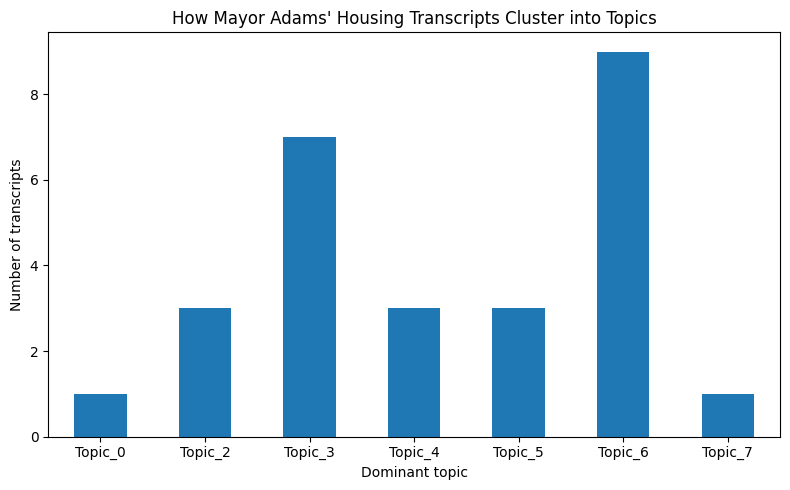

In [14]:
plt.figure(figsize=(8, 5))
topic_counts.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Number of transcripts")
plt.xlabel("Dominant topic")
plt.title("How Mayor Adams' Housing Transcripts Cluster into Topics")
plt.tight_layout()
plt.show()


**Topic 2: The Empathy Frame**

Topic 2 is heavily weighted with terms like "women," "shelter," "park," "son," "family," and "homelessness".

It is devoid of the technical jargon of zoning or the triumphalism of construction.

Instead, it focuses on the visceral experience of housing insecurity. The presence of "women" and "families" suggests a deliberate gendered framing of the crisis: focusing on mothers and children to evoke urgency and compassion.

This topic is likely deployed during announcements regarding shelter openings or tragedies, serving to humanize the administration’s bureaucratic efforts.

**Topic 4: The Modernization Frame**

Distinct from the shelter topic is Topic 4, characterized by "nycha," "community," "access," "digital," and "internet".

This cluster reveals a specific narrative around public housing: modernization.

The focus is not just on structural repairs (roofs/boilers) but on "access" and "digital equity." This reframes the preservation of public housing as a 21st-century civil rights issue, moving beyond the "managed decline" narrative often associated with NYCHA.

**Topic 0: The Governance and Power Frame**

Topic 0 aggregates "majority," "union," "governor," "leader," and "crowd".

This is the "Political Victory" frame. It is used less to discuss policy details and more to celebrate the passage of policy.

It creates an atmosphere of momentum and consensus. When the administration needs to project strength or announce a major legislative win (like state-level housing deals), this topic dominates, emphasizing that the Mayor has the "majority" and the "unions" on his side.



In [15]:
# Build a list of top words per topic
n_top_words = 10
topic_words = []

for k, topic in enumerate(lda.components_):
    top_idx = topic.argsort()[::-1][:n_top_words]
    topic_words.append(vocab[top_idx])


## Personal Note
The per-document topic mixtures are especially revealing.

When I look at the dominant topic for each transcript, I see that some events are almost entirely about a single frame. For example, a bill-signing ceremony that is overwhelmingly driven by the legislative/land-use topic, or a rally transcript dominated by the union–labor topic.

Others are more mixed, such as a “record-breaking year” speech that blends the crisis/money topic with supportive housing and development partners.

This variation supports the idea that the narrative is responsive to context: at a rally, the mayor speaks in the language of allies and movements; at a bill signing, in the language of law and land; at a NYCHA event, in the language of health, access, and residents.

## Limitations
There are important limitations throughout the process. These transcripts are curated, on-message events; they do not capture off-the-cuff remarks, neighborhood-level meetings, or the voices of tenants and advocates.

TF–IDF and LDA also treat all words as equally truthful signals, ignoring whether certain themes are over-emphasized relative to actual budget allocations or unit production.

Future steps would include tracking these topics over time. For example, asking whether supportive-housing language intensifies after specific street-homelessness incidents, or whether “union” and “labor” language spikes near contract negotiations.

Another extension would be to compare the mayor’s rhetoric with independent data on unit completions, shelter census, or NYCHA repairs, to test whether certain frames are used more when performance metrics lag.

## Conclusion
The text analysis reveals that the Adams administration’s housing messaging is a sophisticated balancing act. It does not choose between "affordability" and "development"; rather, it synthesizes them.

By wrapping "construction" (the controversial mechanism) in the language of "supportive services" (the moral imperative) and "union jobs" (the economic benefit), the administration attempts to neutralize opposition to development.

The "balance" asked by the research question is achieved through integration: Rental affordability is rarely discussed as an abstract market dynamic but is grounded in the "services" the city provides and the "partnerships" with the state that make it possible.

The data reveals an administration attempting to shift the Overton window, transforming "pro-development" from a dirty word into a synonym for "pro-union," "pro-health," and "pro-family." This "Narrative Infrastructure" is as crucial to the Mayor's housing strategy as the physical buildings themselves.